The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [1]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.datasets import make_moons
from homegrad.nn import Module
from homegrad.nn import Neuron
from homegrad.nn import Layer
from homegrad.nn import MLPerceptron
from homegrad.engine import * 
from homegrad.drawer import * 

%matplotlib inline

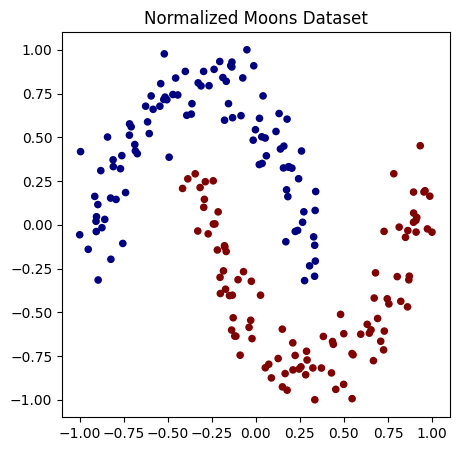

In [2]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 200, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# Min-max normalization for X between -1 and 1
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = 2 * (X - X_min) / (X_max - X_min) - 1

# Visualize normalized data in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=y, s=20, cmap='jet')
plt.title("Normalized Moons Dataset")
plt.show()

In [3]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(200, 2)


In [4]:

#print(MLPerceptron.__init__.__code__.co_varnames)
n = MLPerceptron(2,[16,16,1], activations = ['tanh', 'tanh', 'none' ])
print(n)
print(len(n.parameters()))



MLP of [Layer of [Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2), Tanh Neuron(2)], Layer of [Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16), Tanh Neuron(16)], Layer of [Linear Neuron(16)]]
337


In [5]:
# loss function
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(n, inputs))
    
    # svm "max-margin" loss
    losses = [(Value(1) + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in n.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)



total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8571903881199575, grad=0) 0.565


In [6]:
print(f"Initial loss: {total_loss.data}, accuracy: {acc*100}%")
print("Some initial parameter values:", [p.data for p in n.parameters()[:5]])

Initial loss: 0.8571903881199575, accuracy: 56.49999999999999%
Some initial parameter values: [0.26753945692053627, 0.7879364357457113, 0, -0.4196021006614197, -0.8474021959678977]


In [7]:
#Drawing function, takes too long to run for some reason? 
#draw_dot(total_loss)

In [8]:
#Testing draw_dot
#draw_dot(n((0.5,0.5)))

In [9]:
for k in range(100):
    # forward
    total_loss, acc = loss()
    
    # backward
    n.zero_grad()
    total_loss.backward()
    
    # Debugging: Check gradients
    if k == 0:
        print("Some initial gradients:", [p.grad for p in n.parameters()[:5]])
    
    # update (sgd)
    learning_rate = 0.1
    for p in n.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
        # Debugging: Check updated parameter values
        print("Some updated parameter values:", [p.data for p in n.parameters()[:5]])

Some initial gradients: [-0.18524888443837026, 0.09370825631246585, -0.05914323511382848, -0.3454204743057854, 0.3263127289893904]
step 0 loss 0.8571903881199575, accuracy 56.49999999999999%
Some updated parameter values: [0.2860643453643733, 0.7785656101144647, 0.005914323511382848, -0.38506005323084114, -0.8800334688668368]
step 10 loss 0.33194868305816644, accuracy 86.5%
Some updated parameter values: [0.28353786814946613, 0.7719945955121306, 0.010446008962823388, -0.41173608015323193, -0.8983915575661948]
step 20 loss 0.2793762907261835, accuracy 88.0%
Some updated parameter values: [0.2774801378570134, 0.768883430475613, 0.010075839922654789, -0.43846737200303093, -0.8925674927882236]
step 30 loss 0.24116663029915747, accuracy 89.0%
Some updated parameter values: [0.27275456169649676, 0.7661753649645657, 0.0033937961645462583, -0.4673261437789862, -0.8826655078261649]
step 40 loss 0.1969000766133094, accuracy 91.0%
Some updated parameter values: [0.27040496701541844, 0.76208991822

In [10]:
#testing
print(n.layers[0].neurons[3].w[0].grad)

-0.011946865748378539


Final loss: 0.07813999106282224, accuracy: 99.0%


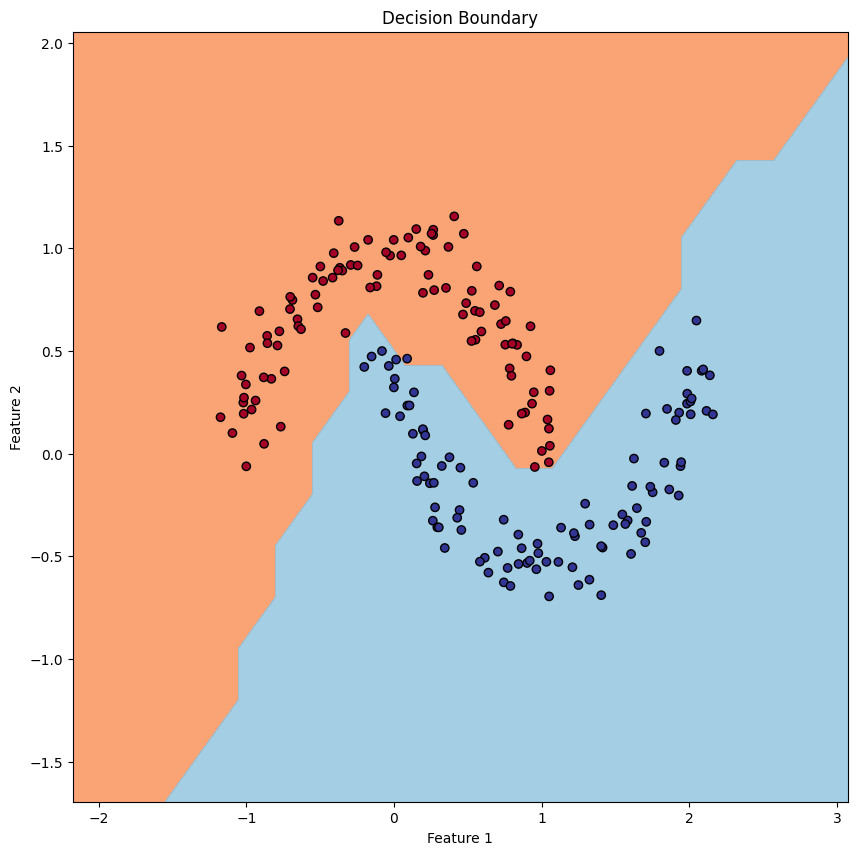

In [11]:
# visualize decision boundary

# Final evaluation
final_loss, final_acc = loss()
print(f"Final loss: {final_loss.data}, accuracy: {final_acc*100}%")

# Plot decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(n, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()